In [1]:
from astropy.io import fits
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
import seaborn as sn
import pickle
if("Analysis" in os.getcwd()):
    os.chdir("../Data_handling")

from pca_functions import Pca_Fitting
from gaia_query import gaia_cone, bailer_jones_cone, concatenate_gaia_bailer
from vae import Encoder,Decoder, VAE , loss_function, model_train
from sp_vae import ModelVAE,model_trains

os.chdir("../Analysis")
os.getcwd()

'/Users/mattocallaghan/GES/Analysis'

In [2]:
sn.set_style('darkgrid') # darkgrid, white grid, dark, white and ticks
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels
plt.rc('legend', fontsize=13)    # legend fontsize
plt.rc('font', size=13)  

In [3]:
os.chdir('../cluster_files')

In [4]:
vae_data=pd.read_csv('vae_data.csv')
#vae_data=pd.read_csv('vae_data_full.csv')

In [5]:
os.chdir('../Analysis')

For now we will drop the nan values for training the VAE

In [6]:
vae_data.columns

Index(['Unnamed: 0', 'bp_rp', 'mean_absolute_mag_g_band', 'prob', 'ra', 'dec',
       'parallax', 'VRAD', 'pmra', 'pmdec', 'phot_g_mean_mag', 'bp_g', 'g_rp',
       'rgeo'],
      dtype='object')

In [7]:
vae_data=vae_data.dropna()

In [8]:
vae_data

,Unnamed: 0,bp_rp,mean_absolute_mag_g_band,prob,ra,dec,parallax,VRAD,pmra,pmdec,phot_g_mean_mag,bp_g,g_rp,rgeo
0,0,1.330919,38.262669,2.272232e-105,282.565031,-6.258065,0.558562,30.64,0.776237,-6.756839,16.820326,0.590866,0.740053,1942.98157
1,1,1.458172,41.751920,1.560951e-97,282.583418,-6.192254,0.376980,105.47,-1.612175,-4.640347,17.810553,0.413675,1.044496,6141.48389
2,2,1.252724,39.021232,6.492006e-05,282.592885,-6.329504,0.375033,39.07,-2.393408,-4.043109,16.887486,0.575531,0.677193,2671.46338
3,3,1.342695,37.603998,1.407040e-289,282.596724,-6.241452,0.523459,-43.21,-3.040533,-0.931751,16.224398,0.585712,0.756983,1887.64343
4,4,1.233818,37.747092,5.012303e-49,282.596739,-6.257442,0.395225,-5.76,-0.711199,-4.404408,15.882403,0.529069,0.704749,2360.14062
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25777,25777,1.685307,41.518770,1.672779e-29,282.788470,-6.007469,0.030766,0.00,-2.850967,-5.665195,17.267374,0.790930,0.894377,7084.01074
25778,25778,1.605724,38.143671,0.000000e+00,282.780248,-6.007047,0.449862,0.00,1.577184,3.119071,16.531607,0.720057,0.885668,2100.93555
25779,25779,2.963137,41.491576,3.309349e-07,282.775456,-6.005157,0.002803,0.00,-1.806624,-4.939151,17.039620,1.733685,1.229452,7769.46533
25780,25780,1.505640,40.704406,2.134537e-18,282.703295,-6.011748,0.209325,0.00,-3.147602,-4.699169,17.225449,0.667429,0.838211,4963.53955


In [9]:
from sklearn.preprocessing import  MinMaxScaler
import torch
scaler=MinMaxScaler()

In [10]:
column_names=['pmra', 'pmdec',
       'rgeo']


#column_names_no_p=['bp_rp','ra','dec','VRAD','pmra','pmdec','phot_g_mean_mag','bp_g','g_rp']
column_names

['pmra', 'pmdec', 'rgeo']

In [11]:
#scaled_data=scaler.fit_transform(vae_data[['bp_rp','phot_g_mean_mag','rgeo','bp_g','g_rp']].values)
#scaled_data=scaler.fit_transform(vae_data[['bp_rp','mean_absolute_mag_g_band']].values)
scaled_data=scaler.fit_transform(vae_data[column_names].values)
#scaled_data=vae_data[column_names].values

# Scaled, non inverted HR diagram

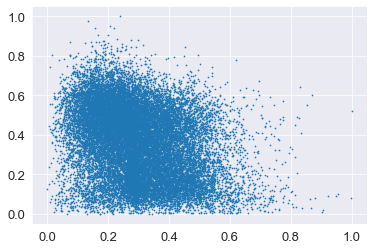

In [12]:
plt.scatter(scaled_data.transpose()[1],scaled_data.transpose()[2],s=0.5)

# Variational Autoencoder

Here we are going to use two different ways and see how they compare.

In [13]:
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.optim import Adam
from torch.utils.data import DataLoader


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Latent parameters

In [14]:
batch_size = 4915 #617 #factor for 1090
lr = 1e-3
epochs = 100
zdim=5

In [15]:
vae_dataset=DataLoader(torch.tensor(scaled_data).float(),batch_size=batch_size) 

In [16]:
encoder = Encoder(input_dim=scaled_data.shape[1], hidden_dims=[50,5], z_dim=zdim,dropout=0.2)
decoder = Decoder(output_dim=scaled_data.shape[1], hidden_dims = [5,50], z_dim=zdim,dropout=0.2)
model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)
optimizer=Adam(model.parameters(),lr=lr)

### The github defined one.

#----------

In [17]:

'''model1=ModelVAE(h_dim=200,z_dim=zdim,activation=F.relu,distribution='vmf')
optimizer1=Adam(model1.parameters(),lr=lr)
print("Start training VAE...")
model1.train()
model_trains(vae_spec=vae_dataset,model=model1,optimizer=optimizer1,epochs=epochs,batch_size=batch_size)'''

'model1=ModelVAE(h_dim=200,z_dim=zdim,activation=F.relu,distribution=\'vmf\')\noptimizer1=Adam(model1.parameters(),lr=lr)\nprint("Start training VAE...")\nmodel1.train()\nmodel_trains(vae_spec=vae_dataset,model=model1,optimizer=optimizer1,epochs=epochs,batch_size=batch_size)'

#--------------

### Train my original explicit one

In [18]:
print("Start training VAE...")
model.train()
z_an,kld=model_train(vae_spec=vae_dataset,model=model,optimizer=optimizer,loss_function=loss_function,epochs=epochs,batch_size=batch_size)


Start training VAE...
	Epoch 1 complete! 	Average Loss:  2.7392009870930822
Overall Loss:  53852.69140625
KLD Loss:  tensor(3678.2146, grad_fn=<MulBackward0>)
	Epoch 2 complete! 	Average Loss:  2.7075723828522382
Overall Loss:  53230.873046875
KLD Loss:  tensor(3613.4329, grad_fn=<MulBackward0>)
	Epoch 3 complete! 	Average Loss:  2.6786619106847662
Overall Loss:  52662.4931640625
KLD Loss:  tensor(3554.6179, grad_fn=<MulBackward0>)
	Epoch 4 complete! 	Average Loss:  2.653541752765768
Overall Loss:  52168.630859375
KLD Loss:  tensor(3498.6785, grad_fn=<MulBackward0>)
	Epoch 5 complete! 	Average Loss:  2.6299404326678535
Overall Loss:  51704.62890625
KLD Loss:  tensor(3444.1223, grad_fn=<MulBackward0>)
	Epoch 6 complete! 	Average Loss:  2.6114260296127925
Overall Loss:  51340.6357421875
KLD Loss:  tensor(3388.1313, grad_fn=<MulBackward0>)
	Epoch 7 complete! 	Average Loss:  2.593202161352365
Overall Loss:  50982.3544921875
KLD Loss:  tensor(3327.7869, grad_fn=<MulBackward0>)
	Epoch 8 comp

### Look at the KLD of main model.

In [19]:
for i in range (len(z_an)):
    z_an[i]=z_an[i].detach().numpy()

for i in range (len(kld)):
    kld[i]=kld[i].detach().numpy()    

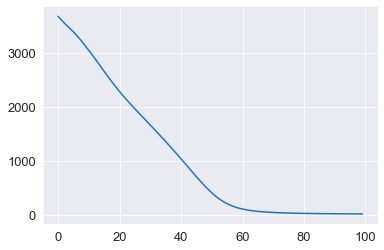

In [20]:
plt.plot(kld)

# Model evaluations

In [21]:
'''model1.eval()
(z_mean, z_var), (q_z, p_z), z1, x_=model1(torch.tensor(scaled_data).float())
z1=z1.detach().numpy()
x_=x_.detach().numpy()'''

'model1.eval()\n(z_mean, z_var), (q_z, p_z), z1, x_=model1(torch.tensor(scaled_data).float())\nz1=z1.detach().numpy()\nx_=x_.detach().numpy()'

In [22]:
model.eval()
x_recon=model(torch.tensor(scaled_data).float())[0].detach().numpy()
zmean=model(torch.tensor(scaled_data).float())[1].detach().numpy()
z=model(torch.tensor(scaled_data).float())[3].detach().numpy()

# Compare the reconstructions

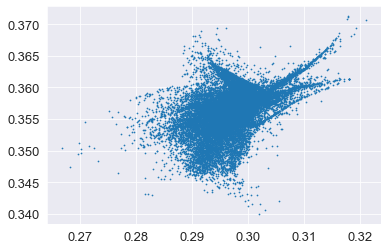

In [23]:
plt.scatter(x_recon.transpose()[1], x_recon.transpose()[2],s=0.5)
#plt.scatter(x_.transpose()[0], x_.transpose()[1],s=0.5)

In [37]:
z_list=['z1','z2','z3','z4','z5']

In [38]:
vae_data[z_list]=z

In [39]:
#vae_data[['z11','z12','z13']]=z1

<Figure size 1080x720 with 0 Axes>

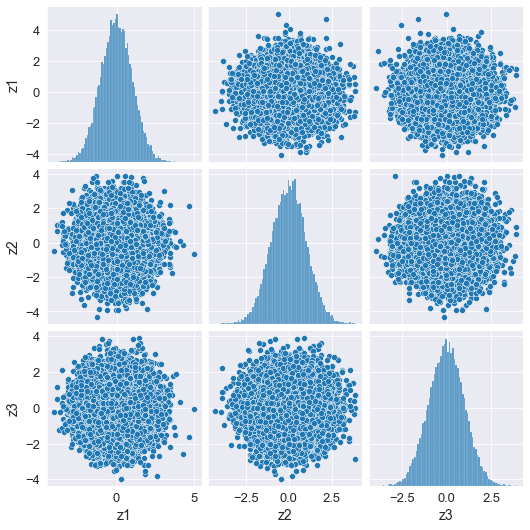

In [40]:
plt.figure(figsize=(15,10))
sn.pairplot(vae_data[z_list[0:3]])
#sn.pairplot(vae_data[['z11','z12','z13']])

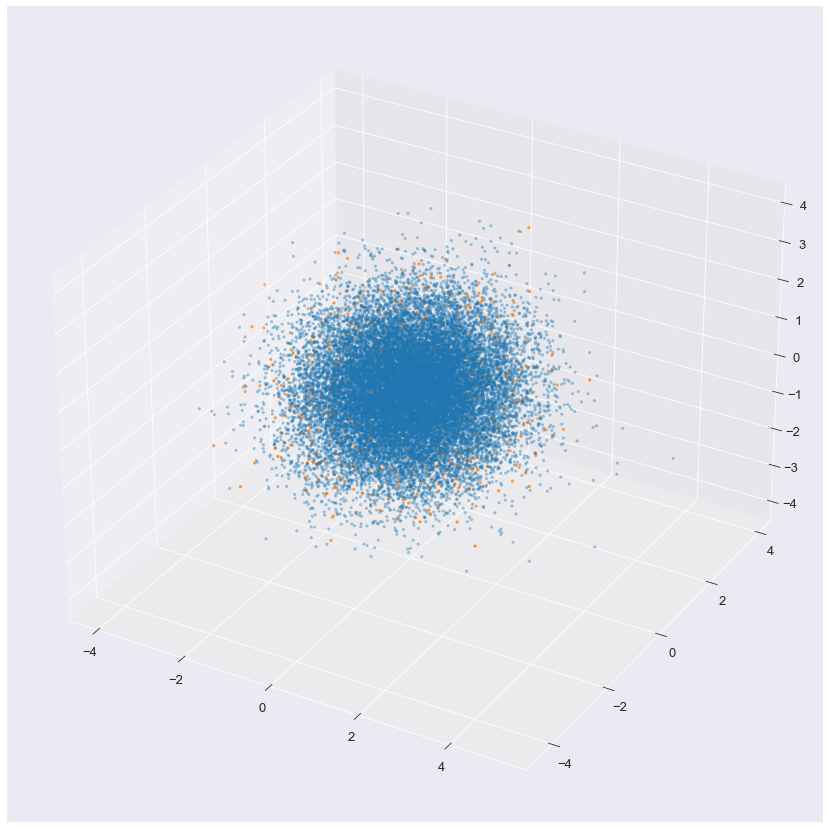

In [41]:
fig = plt.figure(figsize=(15,15))


ax = fig.add_subplot(111, projection='3d') # Method 2

x=vae_data[vae_data['prob']<=0.9]
y=vae_data[vae_data['prob']>0.9]
ax.scatter(x['z1'], x['z2'], x['z3'],s=5,alpha=0.3)
ax.scatter(y['z1'], y['z2'], y['z3'],s=5)


plt.show()

<AxesSubplot:xlabel='z1', ylabel='z2'>

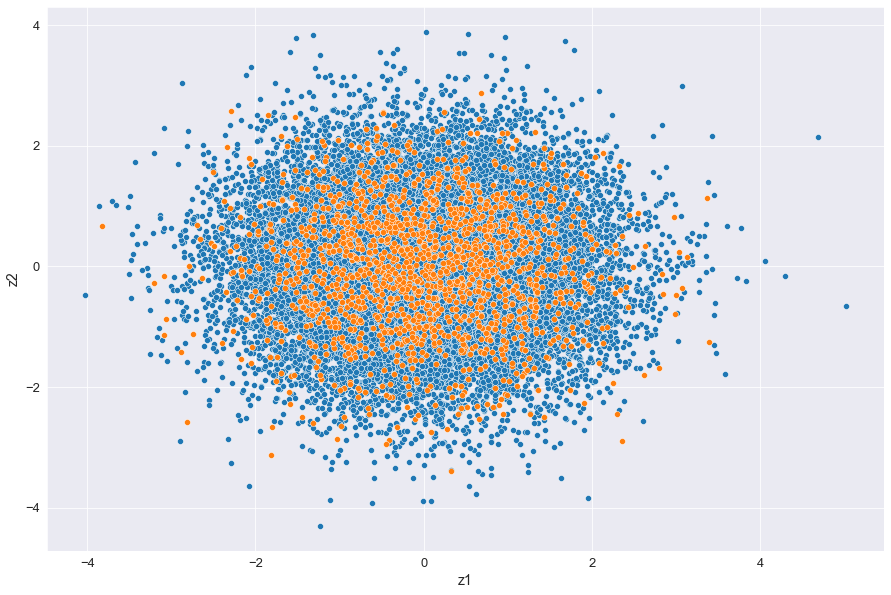

In [42]:
plt.figure(figsize=(15,10))
sn.scatterplot(data=vae_data[vae_data['prob']<=0.9],x='z1',y='z2')
sn.scatterplot(data=vae_data[vae_data['prob']>0.9],x='z1',y='z2')

# Now let us see if we can cluster well on this latent space

In [43]:
from sklearn.mixture import GaussianMixture

In [44]:
gm = GaussianMixture(n_components=3 ,random_state=0).fit(vae_data[z_list].values)

In [45]:
z_list

['z1', 'z2', 'z3', 'z4', 'z5']

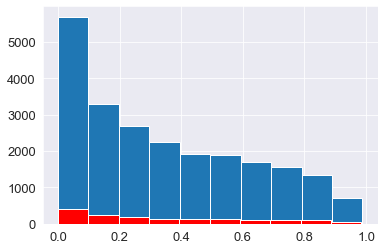

In [46]:
i=1
plt.hist(gm.predict_proba(vae_data[vae_data['prob']<=0.9][z_list].values).transpose()[i])
plt.hist(gm.predict_proba(vae_data[vae_data['prob']>0.9][z_list].values).transpose()[i],color='r')
plt.show()

vae_data['prob2']=gm.predict_proba(vae_data[z_list].values).transpose()[i]

This seems to be working okay.

Check it on a HR diagram

In [47]:
data_for_hr1_full=vae_data[vae_data['prob2']>0.9]
data_for_hr2_full=vae_data[vae_data['prob']>0.9]
both_solution=data_for_hr1_full[vae_data['prob']>0.9]
data_for_hr1_full=data_for_hr1_full[data_for_hr1_full['prob']<=0.9]
data_for_hr2_full=data_for_hr2_full[data_for_hr2_full['prob2']<=0.9]

/var/folders/tm/gnjj0w_d6vj9x6q_ww3f6jsw0000gn/T/ipykernel_3689/1280756406.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  both_solution=data_for_hr1_full[vae_data['prob']>0.9]


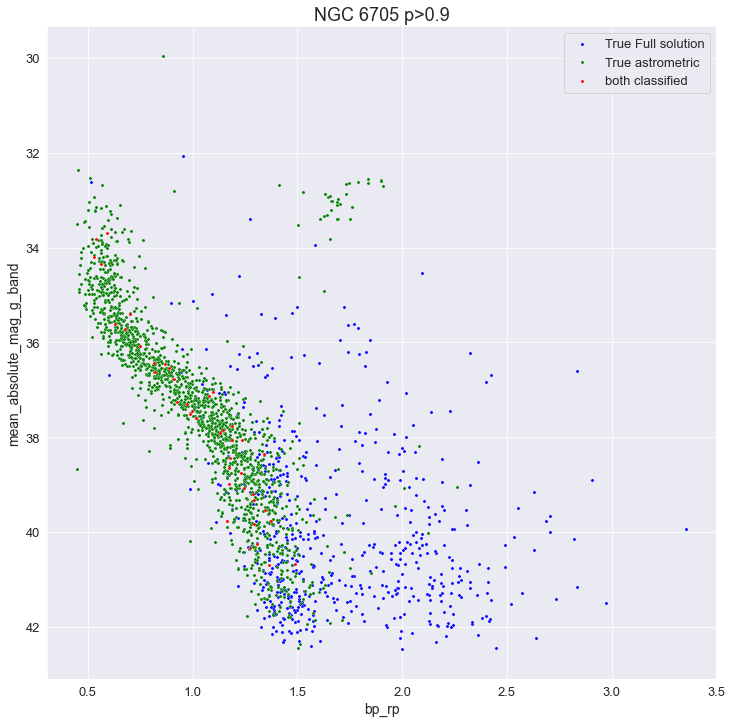

In [48]:
f, axes = plt.subplots(1, 1)
f.set_figheight(12)
f.set_figwidth(12)

scatter=data_for_hr1_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,s=10,label='True Full solution',color='b')

scatter=data_for_hr2_full
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='True astrometric',s=10,color='g')

scatter=both_solution
sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],ax=axes,label='both classified',s=10,color='red')

#axes.set_xlim(0,2.5)
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.show()

<AxesSubplot:xlabel='pmra', ylabel='pmdec'>

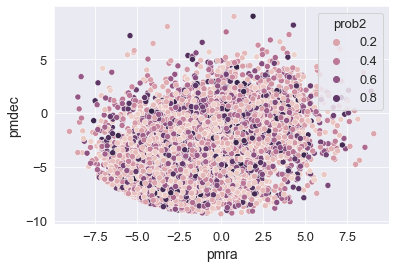

In [49]:
sn.scatterplot(data=vae_data,x='pmra',y='pmdec',hue='prob2')